## Graphical Models
GMs are depictions of independence/dependence relationships for distributions. All GMs have their strengths and weaknesses. Belief networks is one type of a GM, they are useful to represent ancestral conditional independence; however, they cannot always represent dependence relationships.

In this chapter, we will mention Markov networks, chain graphs, and factor graphs.

The framework used for graphical models can be summarized into two parts:
1. **Modelling**
  1. Identify variables in the problem environment.
  2. Describe how these variables interact. This is achieved by making structural assumptions about the joint probability distribution. **Each class of GM corresponds to a factorization property of the joint distribution**.
2. **Inference**
  1. Use algorithms to make inference on GMs.

### Markov Networks
\begin{definition}
A potential $\phi(x)$ is a non-negative function of $x$. A distribution is a special type of potential satisfying $\sum_x \phi(x) = 1$.
\end{definition}

For a set of variables $X = \{x_1, \dots, x_n\}$, a **Markov Network** is defined as a product of potentials on subsets of the variables $X_c \subseteq X$:
$$
p(x_1, \dots, x_n) = \frac{1}{Z}\prod_{c = 1}^C \phi_c(X_c)
$$
where $Z$ is a constant which ensures normalisation, called the partition function. Graphically, this is represented by an undirected graph G with $X_c, c = 1, \dots, C$ being the **maximal cliques** of G. If clique potentials are all strictly positive, then the network is called a Gibbs distribution.

* A **pairwise Markov network** corresponds to an undirected graph $G$ having maximal cliques of size $2$ only.

#### Examples

##### $p(A, B, C, D) = \frac{1}{Z}\phi(A, B)\phi(B, C)\phi(C, D)\phi(A, D)$

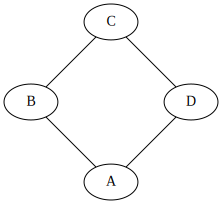

In [3]:
import graphviz as gz
G = gz.Graph()
G.engine = 'circo'
G.edges(['AB', 'BC', 'CD', 'AD'])
G

##### $p(A, B, C, D, E, F) = \frac{1}{Z}\phi(A, B, C)\phi(B, C, D)\phi(D, E)\phi(D, F)$

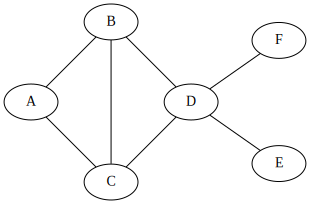

In [7]:
G.clear(keep_attrs=True)
G.edges(['AB', 'BC', 'AC', 'CD', 'BD', 'DE', 'DF'])
G

#### Properties
\begin{definition}
A subset $S$ **separates** a subset $A$ from a subset $B$ (for disjoint $A$ and $B$) if every path from $A$ to $B$ passes through $S$. If there is no path from $A$ to $B$, then $A$ and $B$ are separated even if $S = \varnothing$.
\end{definition}

##### Marginalizing and Conditioning
Let $p(A, B, C) = \phi(A, C)\phi(B, C)/Z$.

* Initially $A$ and $B$ are not independent because of the path from $A$ to $B$.
1. **Marginalizing** over $C$ means we don't have any information on $C$. Not knowing $C$ doesn't get rid of the fact that $A$ and $B$ are not independent. Hence, marginalizing $C$ makes $A$ and $B$ graphically dependent, and in general $p(A, B) \neq p(A)p(B)$.
2. **Conditioning** on $C$ means we know $C$. In this case, $A$ can be explained without knowing $B$ due to the Markov property, and vice versa. Hence, $A \ci B \mid C$.
  * **Markov Property**: If we know the parents of a variable, then the ancestors of the parents doesn't tell us anything new about that variable.
  
##### Global Markov Property
For disjoint sets of variables $(A, B, S)$ where $S$ separates $A$ and $B$ in G, $A \ci B \mid S$.

##### Algorithm for Independence
Due to the separation property, $A \ci B \mid S$ can be easily checked in Markov networs with the following procedure
1. Remove all links that neighbour the set of variables $S$
2. If there is no path between $A$ and $B$, then $A \ci B \mid S$.

##### Local Markov Property
* **Valid for positive potentials**

When conditioned on its neighbours, $x$ is independent of the remaining variables in the graph, i.e. $p(x \mid X \setminus x) = p(x \mid ne(x))$ where $ne(x)$ is the set of neighbours of $x$.

##### Pairwise Markov Property
For any **non-adjacent** vertices $x$ and $y$, $x \ci y \mid X \setminus \{x, y\}$

#### Markov Random Fields
As MRF is defined by a set of distributions $p(x_i \mid ne(x_i))$ where $i$ indexes the distributions. A distribution is an MRF with respect to an undirected graph $G$ if $p(x_i \mid x_{\backslash i}) = p(x_i \mid ne(x_i))$ where $x_{\backslash i} = X \setminus x_i$.

#### Hammersley-Clifford Theorem
Let $G$ be an undirected graph and $F$ be the factorisation as the product of clique potentials defined on $G$.

1. ($G \implies F$): Local Markov property implies that if we know $ne(x)$, we don't need the other variables. If we do this for each variable, then we naturally get a product of maximal clique potentials.
2. ($F \implies G$): Given a factorisation $F$, local Markov properties on $G$ are implied.

See BRML 4.2.3 for a detailed discussion.

#### Conditional Independence in Belief and Markov Networks
For sets of variables $X, Y, Z$, determine whether $X \ci Y \mid Z$.

The following procedure applies to both belief (Bayes) and Markov networks. For Markov networks, only the final separation step is applied.

1. **Ancestral Graph**
  1. Identify the ancestors $A$ of $(X \cup Y \cup Z)$.
  2. For all nodes $n$, if $n \notin (A \cup X \cup Y \cup Z)$, remove $n$ and all edges in/out of $n$.
2. **Moralisation**
  1. For all immoralities $(A, B, C)$ where $C$ is child of both $A$ and $B$,
    1. add a link between $A$ and $B$,
    2. remove link between $A$ and $C$,
    3. remove link between $B$ and $C$.
3. **Separation**
  1. Remove links neighbouring $Z$.
  2. Look for a path from $X$ to $Y$. If there is no such path, then $X \ci Y \mid Z$.

#### Lattice Model for Image Cleaning
An example Lattice model is:

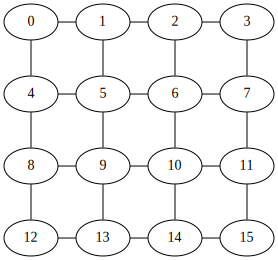

In [147]:
def lattice_graph(n):
    """
    Construct an nxn lattice graph as graphviz.Graph object.
    
    Parameters
    ----------
    n : int
        Number of nodes per row and column.
        
    Returns
    -------
    graph : graphviz.Graph
        Corresponding lattice graph with nodes indexed from 0 to n-1.
    """
    G = gz.Graph()
    for i in range(n):
        with G.subgraph() as S:
            S.attr(rank='same')
            for j in range(n):
                S.node(str(n*i + j))

    edge_set = set()
    for index in range(n*n):
        i, j = divmod(index, n)
        if i > 0:
            edge_set.add(frozenset((index, n*(i - 1) + j)))
        if i < n - 1:
            edge_set.add(frozenset((index, n*(i + 1) + j)))
        if j > 0:
            edge_set.add(frozenset((index, n*i + j - 1)))
        if j < n - 1:
            edge_set.add(frozenset((index, n*i + j + 1)))

    sorted_edges = (sorted(pair) for pair in edge_set)
    str_edges = ((str(first), str(second)) for (first, second) in sorted_edges)
    G.edges(str_edges)
    return G

lattice_graph(4)

and the corresponding Markov network model corresponds to the following joint distribution
$$
p(x_1, \dots, x_9) = \frac{1}{Z}\prod_{i \sim j} \phi_{ij}(x_i, x_j)
$$
where $i \sim j$ if $i$ and $j$ are neighbours.

This model can be thought as representing a locality principle where if we know the neighbours of a node, we know everything we need to know about that node. We can use this idea for images since pixels tend to be similar to their neighbours.

### Chain Graphical Models
Chain Graphs are a mixture of directed models (Bayes Nets) and undirected models (Markov Networks).

#### Example

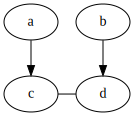

In [165]:
G = gz.Digraph()
with G.subgraph() as S:
    S.attr(rank='same')
    S.node('a')
    S.node('b')
G.edges(['ac', 'bd'])
with G.subgraph() as S:
    S.attr(rank='same')
    S.edge('c', 'd', dir='none')
G

corresponds to $p(a, b, c, d) = p(c, d \mid a, b)p(a)p(b)$ with
$$
p(c, d \mid a, b) = \frac{\phi(c, d)p(c \mid a)p(d \mid b)}{\sum_{c, d} \phi(c, d)p(c \mid a)p(d \mid b)}
$$

A chain graph is a DAG over the chain components. Hence, chain components can be thought of as Markov networks whereas the whole DAG is a belief network over these separate Markov networks.

\begin{definition}
The chain components of a graph $G$ are obtained by
1. Forming a graph $G\prime$ with directed edges removed from $G$
2. Each connected component in $G\prime$ constitutes a chain component
\end{definition}

* A Bayesian Network is a Chain Graph where each connected component is a singleton.
* A Markov Network is a Chain Graph with a single connected component.

---

* Chain graphs can represent independence statements that no Markov or Bayes network can represent alone.
  1. Markov networks can represent cyclic dependencies while Bayes networks cannot.
  2. Bayes networks can represent certain marginal independencies which Markov networks cannot (3 node network with a collider).
  3. A chain graph can represent both of these independence assumptions in a single model.

#### Chain Graph Distribution
The distribution associated with a chain graph $G$ is found by first identifying the chain components, $\tau$ and their associated variables $X_{\tau}$. Then
$$
p(x) = \prod_{\tau} p(X_{\tau} \mid pa(X_{\tau}))
$$
where
$$
p(X_{\tau} \mid pa(X_{\tau})) \propto \prod_{d \in D_{\tau}} p(x_d \mid pa(x_d))\prod_{c \in C_{\tau}} \phi(X_c)
$$
where $C_{\tau}$ denotes the union of the cliques in the component $\tau$, $D_{\tau}$ is the set of variables in component $\tau$ that correspond to directed terms $p(x_d \mid pa(x_d))$. The proportionality factor is determined implicitly by the constraint that the distribution sums to $1$.

##### Example CG Distribution

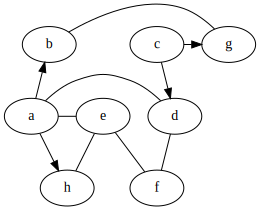

In [183]:
G = gz.Digraph()
for level, rank in [('bgc', 'min'), ('ade', 'same'), ('hf', 'max')]:
    with G.subgraph() as S:
        S.attr(rank=rank)
        for node in level:
            S.node(node)

directed_edges = ['ah', 'ab', 'cd', 'cg']
undirected_edges = ['df', 'ad', 'bg', 'eh', 'ef', 'ae']
G.edges(directed_edges)
for edge in undirected_edges:
    G.edge(edge[0], edge[1], dir='none')

G

When the directed edges are removed, the connected components are $b, cg, aedhf$. Hence, this CG corresponds to the following Bayes Net

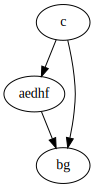

In [184]:
G.clear()
G.edges([('aedhf', 'bg'), ('c', 'bg'), ('c', 'aedhf')])
G

where each node of this Bayes Net is itself a Markov Network. Hence, the overall distribution of the CG can be written as
$$
p(\cdot) \propto p(b \mid a)p(g \mid c)\phi(b, g) \cdot p(d \mid c)\phi(a, e)\phi(e, h)\phi(e, f)\phi(d, f)\phi(a, d) \cdot p(c)
$$

### Factor Graphs
Given a function $f(x_1, \dots, x_n) = \prod_i \psi_i(X_i)$, the factor graph has a node (a square) for each factor $\psi_i$ , and a variable node (circle) for each variable $x_j$. For each $x_j \in X_i$ an undirected link is made between factor $\psi_i$ and variable $x_j$.

When used to represent a distribution, we need to normalize:
$$
p(x_1, \dots, x_n) = \frac{1}{Z}\prod_i \psi_i(X_i)
$$
where $Z = \sum_X \prod_i \psi_i(X_i)$ is the normalisation constant.

If a factor $\psi_i(X_i)$ is a conditional distribution in the form $p(x_i \mid pa(x_i))$, then we can use directed edges from the parents of the factor to the factor, and from the factor to the children of the factor. Directed edges allows us to preserve the information that the factor is a probability distribution.

#### Example
$$
p(a, b, c) = p(a \mid b, c)p(b)p(c).
$$

##### Corresponding Bayes Net

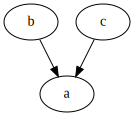

In [185]:
G = gz.Digraph()
G.edges(['ba', 'ca'])
G

##### Corresponding Factor Graph
$$
p(a, b, c) \propto \psi_1(a, b, c)\psi_2(b)\psi_2(c)
$$

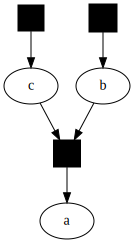

In [199]:
G = gz.Digraph()
G.node('fa', shape='square', style='filled', color='black', width='0.1')
G.node('fb', shape='square', style='filled', color='black', width='0.1')
G.node('fc', shape='square', style='filled', color='black', width='0.1')
G.edges([('fc', 'c'), ('fb', 'b'), ('fa', 'a'), ('b', 'fa'), ('c', 'fa')])
G

#### Factor Graph Conditional Independence
Two disjoint sets of variables $A$ and $B$ are conditionally independent given a third set $C$ if all paths from $A$ to $B$ are blocked. A path is blocked if at least one of the following is satisfied:
1. One of the variables in the path is in the conditioning set
2. One of the variables **or factors** in the path is a collider, and neither the variable/factor nor any of its descendants are in the conditioning set.

### Expressiveness of Graphical Models

#### Bayes Network to Markov Network
Each directed distribution can be represented as an undirected distribution by associating a potential for each factor of the directed distribution. However, transformation from a bayes net to a markov net **may cause information loss!**

\begin{remark}
Markov network associated with a Bayes network is the **moralised** version of the Bayes network. One can moralise a Bayes network by drawing an undirected edge between each pair of unconnected nodes which have a common child.
\end{remark}

##### Moralisation Causes Loss of Independence Information
Consider

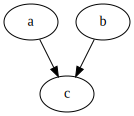

In [200]:
G = gz.Digraph()
G.edges(['ac', 'bc'])
G

In this Bayes net, $a \ci b$. However, if we write the corresponding Markov network

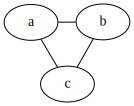

In [203]:
G = gz.Graph()
G.engine = 'neato'
G.edges(['ab', 'bc', 'ac'])
G

we cannot infer from the graph that $a \ci b$. During the transformation process, $a \ci b$ information is lost.

#### Markov Network to Bayes Network
Representing cyclic dependencies is not possible with a Bayes Network

#### Distribution Maps
\begin{definition}
A graph $G$ is an **independence map** of a distribution $P$ if every conditional independence statement that one can derive from $G$ is true in $P$.
  * By contraposition, every dependency statement one can derive from $P$ is true in $G$.

Conversely, a graph $G$ is a **dependence map** of a distribution $P$ if every conditional independence statement that one can derive from $P$ is true in $G$.
  * By contraposition, every dependency statement one can derive from $G$ is true in $P$.

A graph $G$ which is both an I-map and a D-map of distribution $P$ is a **perfect map** of $P$.
\end{definition}

Let $L_P$ be the set of all conditional independence statements one can derive from $P$. Define $L_G$ similarly. Then, according to these definitions,
$
\begin{align}
\text{G is a  D-map} &\implies L_P \subseteq L_G, \\
\text{G is an I-map} &\implies L_G \subseteq L_P, \\
\text{G is a perfect map} &\implies L_G = L_P.
\end{align}
$

##### Maps of Distribution Classes
In this case, all numerical instances of the distribution class must obey the requirements. To do this, $L_P = \cup_i L_{P_i}$ where $P_i$ is a numerical instance of distribution $P$.